In [1]:

import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from scipy.stats import norm
from math import comb

In [ ]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# Données
x = np.array([6, 9, 17, 22, 7, 5, 5, 14, 9, 7, 9, 51])  # PVCs avant traitement
y = np.array([5, 2, 0, 0, 2, 1, 0, 0, 0, 0, 13, 0])   # PVCs après traitement
t = x + y                        # Total des observations

# Hyperparamètres des lois a priori
mu_alpha, sigma_alpha = 0, 2  # Pour logit(p)
mu_delta, sigma_delta = 0, 2  # Pour logit(theta)

# Initialisation des chaînes MCMC
n_iter = 5000
alpha_chain = np.zeros(n_iter)
delta_chain = np.zeros(n_iter)
p_chain = np.zeros(n_iter)
theta_chain = np.zeros(n_iter)

# Valeurs initiales
alpha_chain[0] = np.random.normal(mu_alpha, sigma_alpha)
delta_chain[0] = np.random.normal(mu_delta, sigma_delta)

# Fonction logit et inverse logit
def logit(x):
    return np.log(x / (1 - x))

def inv_logit(x):
    return 1 / (1 + np.exp(-x))

# Algorithme Metropolis-Hastings
for i in range(1, n_iter):
    # Propositions
    alpha_prop = np.random.normal(alpha_chain[i-1], 0.1)
    delta_prop = np.random.normal(delta_chain[i-1], 0.1)
    
    # Transformations
    p_prop = inv_logit(alpha_prop)
    theta_prop = inv_logit(delta_prop)
    
    # Calcul de la vraisemblance
    likelihood_current = np.prod(stats.binom.pmf(y, t, inv_logit(alpha_chain[i-1])))
    likelihood_proposed = np.prod(stats.binom.pmf(y, t, p_prop))
    
    # Calcul des a priori
    prior_current = stats.norm.pdf(alpha_chain[i-1], mu_alpha, sigma_alpha) * stats.norm.pdf(delta_chain[i-1], mu_delta, sigma_delta)
    prior_proposed = stats.norm.pdf(alpha_prop, mu_alpha, sigma_alpha) * stats.norm.pdf(delta_prop, mu_delta, sigma_delta)
    
    # Ratio d'acceptation
    acceptance_ratio = (likelihood_proposed * prior_proposed) / (likelihood_current * prior_current)
    
    # Acceptation ou rejet
    if np.random.rand() < min(1, acceptance_ratio):
        alpha_chain[i] = alpha_prop
        delta_chain[i] = delta_prop
    else:
        alpha_chain[i] = alpha_chain[i-1]
        delta_chain[i] = delta_chain[i-1]
    
    p_chain[i] = inv_logit(alpha_chain[i])
    theta_chain[i] = inv_logit(delta_chain[i])

# Tracé des distributions a posteriori
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.hist(p_chain, bins=30, density=True)
plt.title("Distribution a posteriori de p")

plt.subplot(1, 2, 2)
plt.hist(theta_chain, bins=30, density=True)
plt.title("Distribution a posteriori de θ")
plt.show()

In [3]:
# Données
x = np.array([6, 9, 17, 22, 7, 5, 5, 14, 9, 7, 9, 51])  # PVCs avant traitement
y = np.array([5, 2, 0, 0, 2, 1, 0, 0, 0, 0, 13, 0])   # PVCs après traitement
T = x + y                        # Total des observations

In [65]:

# Fonction logit et inverse logit
def logit(x):
    return np.log(x / (1 - x))

def inv_logit(x):
    return 1 / (1 + np.exp(-x))


def log_posterior(alpha, prior_mu, prior_sd, health_status, y,t,p) :
    
    
    log_prior = norm.logpdf(alpha, prior_mu, prior_sd)
    log_lik = 0.0
    for i in range(len(y)) : 
        if health_status[i] == 1 : 
            if y[i] > 0 : 
                return -np.inf
            
        else : 
            val_i = y[i]*np.log(p) + (t[i]-y[i])*np.log(1-p) 
            if np.isinf(val_i) or np.isnan(val_i):
                return -np.inf
            log_lik += val_i
        
    return log_prior + log_lik
    
    


In [111]:
def heart_mixture_sampler(n_iter,x,y,T) : 
    # Données
    n_individual = len(x)
    
    # Variance des noyaux de propositions
    proposal_sd_alpha = 0.02
    proposal_sd_delta = 0.02

    # Hyperparamètres des lois a priori
    prior_mu_alpha, prior_sd_alpha = 0, 10**(-2)  # Pour logit(p), A REVOIR COMMENT ON CHOISIT NOTRE PRIOR 
    prior_mu_delta, prior_sd_delta = 0, 10**(-2)  # Pour logit(theta)

    # Initialisation des chaînes MCMC
    alpha_chain = np.zeros(n_iter)
    delta_chain = np.zeros(n_iter)
    beta_chain = np.zeros(n_iter)
    p_chain = np.zeros(n_iter)
    theta_chain = np.zeros(n_iter)
    health_status = np.zeros(n_individual)
    
    beta_chain[0] = np.exp(alpha_chain[0])
    p_chain[0] = beta_chain[0] / (1 + beta_chain[0])
    theta_chain[0] = inv_logit(delta_chain[0])
    
    # On stocke les ratio d'accpetation 
    acceptance_ratio_alpha = np.zeros(n_iter)
    
    # On mets à jours les paramètres
    for t in range(1,n_iter) :
        # Mise à jour de alpha via Metropolis-Hastings
        alpha_prop = alpha_chain[t-1] + np.random.normal(0, proposal_sd_alpha) ### A revoir comment on choisit la variance du noyau de proposition 
        acceptance_ratio = np.exp(log_posterior(alpha_prop, prior_mu_alpha, prior_sd_alpha, health_status, y,T,p_chain[t-1]) - log_posterior(alpha_chain[t-1], prior_mu_alpha, prior_sd_alpha, health_status, y,T,p_chain[t-1]))
        acceptance_ratio_alpha[t] = acceptance_ratio
        if np.random.rand() < min(1, acceptance_ratio):
            alpha_chain[t] = alpha_prop 
        else:
            alpha_chain[t] = alpha_chain[t-1]
        
        # Mise à jour de delta via Metropolis-Hastings
        delta_prop = delta_chain[t-1] + np.random.normal(0, proposal_sd_delta) ### A revoir comment on choisit la variance du noyau de proposition 
        acceptance_ratio = np.exp(log_posterior(delta_prop, prior_mu_delta, prior_sd_delta, health_status, y,T,p_chain[t-1]) - log_posterior(delta_chain[t-1], prior_mu_delta, prior_sd_delta, health_status, y,T,p_chain[t-1]))
        if np.random.rand() < min(1, acceptance_ratio):
            delta_chain[t] = delta_prop 
        else:
            delta_chain[t] = delta_chain[t-1]
            
        # Mise à jour de p,theta et beta
        beta_chain[t] = np.exp(alpha_chain[t])
        p_chain[t] = beta_chain[t] / (1 + beta_chain[t])
        theta_chain[t] = inv_logit(delta_chain[t])
        
        # Mise à jour des variables latentes 
        for i in range(n_individual):
            if y[i] > 0:                 # Pas possible d'être guéri
                health_status[i] = 0
            else:                        # On tire un Bernoulli
            
                numerator = theta_chain[t]
                denominator = theta_chain[t] + (1 - theta_chain[t])*( (1-p_chain[t])**T[i] )
                prob_gueri = numerator/denominator
                
                # health_status[i] = 1 si unif < prob_gueri, sinon 0
                if np.random.rand() < prob_gueri:
                    health_status[i] = 1
                else:
                    health_status[i] = 0
                    
    acceptance_ratio_alpha = np.mean(acceptance_ratio_alpha)
        
    return alpha_chain, delta_chain, p_chain, theta_chain, health_status, acceptance_ratio_alpha
        
    
    


1.0134405306602285


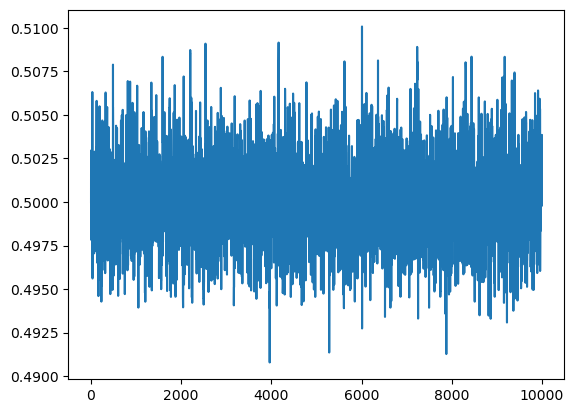

In [112]:
alpha_chain, delta_chain, p_chain, theta_chain, health_status, acceptance_ratio_alpha = heart_mixture_sampler(10000,x,y,T)

print(acceptance_ratio_alpha)
plt.plot(theta_chain)